In this project, we will build a neural network to automatically segment tumor region in brain using MRI (Magnetic Resonance imaging) scans. The MRI scan is one of the most common image modalities that we encounter in the radiology field.

In [1]:
print(dir())
# %reset -f
# dir()

['In', 'Out', '_', '__', '___', '__builtin__', '__builtins__', '__doc__', '__loader__', '__name__', '__package__', '__spec__', '__vsc_ipynb_file__', '_dh', '_i', '_i1', '_ih', '_ii', '_iii', '_oh', 'exit', 'get_ipython', 'open', 'quit']


In [3]:
### Importing Modules
import tensorflow as tf
import keras
import json
import numpy as np
import pandas as pd
import nibabel as nib # nibabel will let us extract the images and labels from the files in our dataset.
from tensorflow.keras import backend as K 
import os

os.chdir("/diazlab/data3/.abhinav/.learning/PredictiveModelling/Brain_Tumor_MRI_Segmentation/")
import util

import cv2
import h5py
import imageio
import keras
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from IPython.display import Image
from keras import backend as K
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import (
    Activation,
    Conv3D,
    Conv3DTranspose,
    MaxPooling3D,
    UpSampling3D
)

from tensorflow.keras.layers import concatenate
from keras.optimizers import Adam
from keras.utils import to_categorical
from tensorflow.compat.v1.logging import INFO, set_verbosity


2025-03-14 10:30:04.622910: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-14 10:30:05.523983: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741973405.606766 1846046 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741973405.631122 1846046 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-14 10:30:06.165904: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

## 1.2 MRI Data Processing
We often encounter MR images in the DICOM format.
The DICOM format is the output format for most commercial MRI scanners. This type of data can be processed using the pydicom Python library.
In this project, we will be using the data from the Decathlon 10 Challenge. This data has been mostly pre-processed for the competition participants, however in real practice, MRI data needs to be significantly pre-preprocessed before we can use it to train our models.

## 1.3 Exploring the Dataset
Our dataset is stored in the [NifTI-1 format](https://nifti.nimh.nih.gov/nifti-1/) and we will be using the [NiBabel library](https://github.com/nipy/nibabel) to interact with the files. 
Each training sample is composed of two separate files:

The first file is an image file containing a 4D array of MR image in the shape of (240, 240, 155, 4). 
-  The first 3 dimensions are the X, Y, and Z values for each point in the 3D volume, which is commonly called a voxel. 
 - The 4th dimension is the values for 4 different sequences
     - 0: FLAIR: "Fluid Attenuated Inversion Recovery" (FLAIR)
     - 1: T1w: "T1-weighted"
     - 2: t1gd: "T1-weighted with gadolinium contrast enhancement" (T1-Gd)
     - 3: T2w: "T2-weighted"

 The second file in each training example is a label file containing a 3D array with the shape of (240, 240, 155).  
 - The integer values in this array indicate the "label" for each voxel in the corresponding image files:
     - 0: background
     - 1: edema
     - 2: non-enhancing tumor
     - 3: enhancing tumor


In [4]:
### Loading and exploring the dataset
# set home directory and data directory
HOME_DIR = "/diazlab/data3/.abhinav/.learning/PredictiveModelling/Brain_Tumor_MRI_Segmentation/rawdata/Task01_BrainTumour/"
DATA_DIR = HOME_DIR

def load_case(image_nifty_file, label_nifty_file):
    # load the image and label file, get the image content and return a numpy array for each
    image = np.array(nib.load(image_nifty_file).get_fdata())
    label = np.array(nib.load(label_nifty_file).get_fdata())
    
    return image, label

In [5]:
image, label = load_case(DATA_DIR + "imagesTr/BRATS_003.nii.gz", DATA_DIR + "labelsTr/BRATS_003.nii.gz")

In [6]:
### In this rows, columns and third dimension are length, width and heigth (x,y,z). while inside are values like in image it is intensities
# and labels are labels from 0 to 3. 
print(label.shape)
print(image.shape) 
print(label[1,:,:].shape)
print(label[:, :, 154].shape)
print(label[:, 1, :].shape)

(240, 240, 155)
(240, 240, 155, 4)
(240, 155)
(240, 240)
(240, 155)


#### Preprocessing the image so that we can visualize the image

In [7]:
import numpy as np
import cv2
from tensorflow.keras.utils import to_categorical


In [ ]:
mask = label != 4 ### Since labels has only 4 values so to include all the index I have used this 4. You can use any other value than 0,1,2,3
print(label[mask].shape)
# Get unique values and their counts
unique_values, counts = np.unique(label[mask], return_counts=True)
print(pd.DataFrame(unique_values, counts))


(8928000,)
           0
8754073  0.0
148263   1.0
4414     2.0
21250    3.0


In [9]:
print(label.shape)
# If label is not in a categorical (one-hot encoded) format, it is converted into a one-hot encoded representation using to_categorical.
# Assumes 4 classes, meaning each voxel in label gets transformed into a one-hot vector with 4 elements.
# The output shape will be (H, W, D, 4) where:
# The last dimension represents different classes (background, tumor, edema, etc.).
# Each voxel belongs to only one class, represented by a 1 in the corresponding channel.
## One-hot encoding: The function transforms the integer labels (e.g., 0, 1, 2, etc.) into binary vectors with a single 1 at the position corresponding to the class, and 0s elsewhere.

label = to_categorical(label, num_classes=4).astype(np.uint8)
print(label.shape)

(240, 240, 155)
(240, 240, 155, 4)


In [10]:
### Since it is binary now so we can do 2 that is different from 0 and 1
mask = label != 2
print(label[mask].shape)
# Get unique values and their counts
unique_values, counts = np.unique(label[mask], return_counts=True)
print(pd.DataFrame(unique_values, counts))


(35712000,)
          0
26784000  0
8928000   1


In [ ]:
print(image.shape)
mask = image != 5
print(image[mask].shape)
# Get unique values and their counts for the intensity in the image array
unique_values, counts = np.unique(image[mask], return_counts=True)
print(pd.DataFrame(unique_values, counts))


(240, 240, 155, 4)
(35708400,)
               0
28739767     0.0
1350         1.0
6908         2.0
2931         3.0
2967         4.0
...          ...
1         3412.0
1         3416.0
1         3453.0
1         3488.0
1         3533.0

[2077 rows x 1 columns]


In [13]:
image[image[:,:,:,0] != 0] ### First Channel which is not equal to 0

array([[ 31.,  90.,  49.,  20.],
       [ 61., 204., 142.,  36.],
       [ 51., 150., 125.,  34.],
       ...,
       [112., 248., 234.,  97.],
       [173., 350., 410.,  84.],
       [ 31.,  11.,  52.,   0.]], shape=(1690470, 4))

In [14]:
print(image.shape)
# The image (assumed to be grayscale) is normalized to the range [0, 255] using OpenCV’s cv2.normalize().
# Only the first channel image[:, :, :, 0] is used, assuming that the original data has multiple channels (e.g., multi-modal MRI), but only one is visualized.
# Converts it into an 8-bit unsigned integer (np.uint8) so it can be displayed easily.
image = cv2.normalize(image[:, :, :, 0], None, alpha=0, beta=255,norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F).astype(np.uint8)
print(image.shape) ### has only 1 channel

(240, 240, 155, 4)
(240, 240, 155)


In [16]:
mask = image != 256 ### Since it has been changed to 0 to 255 for better visualization
print(image[mask].shape)
# Get unique values and their counts
unique_values, counts = np.unique(image[mask], return_counts=True) 
print(pd.DataFrame(unique_values, counts))

(8928000,)
           0
7244577    0
5026       1
4448       2
4421       3
4933       4
...      ...
2        231
1        239
1        245
1        246
1        255

[233 rows x 1 columns]


In [ ]:
labeled_image = np.zeros_like(label[:, :, :, 1:]) ### this is a zero array with the same dimension as label without the background
print(labeled_image.shape)

## We are generating the labeled image to add the image intensity without the background for better visualization
mask = labeled_image != 2 ### Since it has only 0
print(labeled_image[mask].shape)
# Get unique values and their counts
unique_values, counts = np.unique(labeled_image[mask], return_counts=True) 
print(pd.DataFrame(unique_values, counts))

(240, 240, 155, 3)
(26784000,)
          0
26784000  0


In [18]:
# Multiplies the image with the background mask (label[:, :, :, 0]).
# This operation keeps only the background part in grayscale while removing the tumor regions, which we will add different in the next chunks
labeled_image[:, :, :, 0] = image * (label[:, :, :, 0])
labeled_image[:, :, :, 1] = image * (label[:, :, :, 0])
labeled_image[:, :, :, 2] = image * (label[:, :, :, 0])

In [19]:
mask = labeled_image != 256 ### Since it has been changed to 0 to 255 for better visualization
print(labeled_image[mask].shape)
# Get unique values and their counts
unique_values, counts = np.unique(labeled_image[mask], return_counts=True) 
print(pd.DataFrame(unique_values, counts))

(26784000,)
            0
22255155    0
15063       1
13344       2
13260       3
14799       4
...       ...
6         231
3         239
3         245
3         246
3         255

[233 rows x 1 columns]


In [20]:
# Add color labels for non-background classes
# Adds the segmented labels (excluding the background) multiplied by 255 to make them visible.
# Each class (tumor subregions) is assigned a color:
# Necrotic core, edema, enhancing tumor → Will appear in different colors due to the one-hot encoded mask.
print("shape of label: ",label.shape)
print("shape of labeled image: ",labeled_image.shape)
labeled_image += label[:, :, :, 1:] * 255 ### Adding on the top of the background
print(labeled_image.shape)

shape of label:  (240, 240, 155, 4)
shape of labeled image:  (240, 240, 155, 3)
(240, 240, 155, 3)


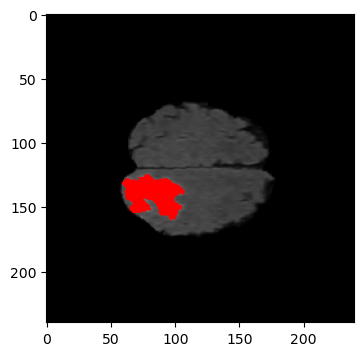

In [21]:
### Checking the image
fig, ax = plt.subplots(1,1, figsize = [4,4]) 
ax.imshow(np.squeeze(labeled_image[:, :, 124, :]))

(240, 240, 155, 3)
Coronal dimension:  (155, 240, 240, 3, 1)
Transversal dimension:  (240, 240, 155, 3, 1)
Sagittal dimension:  (155, 240, 240, 3, 1)


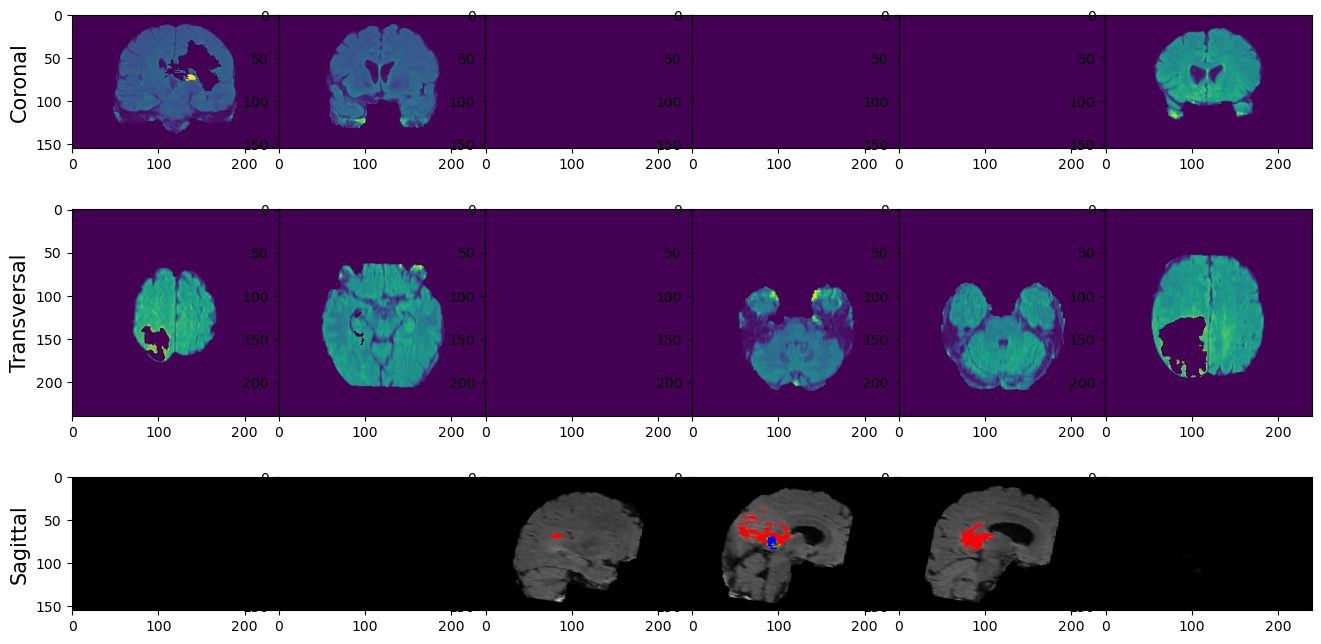

In [ ]:
### Plotting it
data_all = []
data_all.append(labeled_image)
print(data_all[0].shape)
### Preparing for different planes i.e. coronal, saggital, and transversal

fig, ax = plt.subplots(3,6, figsize = [16,9]) ### In 3 row and 6 columns with figure size 16 * 9
### Coronal 
# Specifically, it switches the axes such that the coronal view corresponds to a specific rearrangement of the data.
# The axis [1, 3, 2, 4, 0] transforms the image so that the first dimension corresponds to the height (Y), the second corresponds to depth (Z), and the third corresponds to width (X).
# here 0 represent the first image with index 0
# 4 is the channel that could be gray scale or multi-channel
coronal = np.transpose(data_all, [1, 3, 2, 4, 0]) 
coronal = np.rot90(coronal, 1)
print("Coronal dimension: ",coronal.shape)

# transversal plane
transversal = np.transpose(data_all, [2, 1, 3, 4, 0])
transversal = np.rot90(transversal, 2)
print("Transversal dimension: ",transversal.shape)

# sagittal plane
sagittal = np.transpose(data_all, [2, 3, 1, 4, 0])
sagittal = np.rot90(sagittal, 1)
print("Sagittal dimension: ",sagittal.shape)

# Coronal
# The slicing [:, :, n, :] extracts:
#     All values in the first dimension (:) → height (Y-axis)
#     All values in the second dimension (:) → width (X-axis)
#     A single slice along the depth (n) → selecting the n-th coronal slice
#     All channels (:) → keeps all color channels (if applicable, e.g., grayscale or RGB)
# The result is a 2D image (height × width) with potential extra dimensions if the image has multiple channels.

# np.squeeze(coronal[:, :, n, :])
# np.squeeze() removes singleton (size-1) dimensions.
# If the image is grayscale, the channel dimension might be (H, W, 1). np.squeeze() converts it to (H, W) so that imshow() can display it correctly.
# example
# coronal[:, :, 25, :].shape  # (256, 256, 1)
# np.squeeze(coronal[:, :, 25, :]).shape  # (256, 256)

for i in range(6):
    n = np.random.randint(coronal.shape[2])
    ax[0][i].imshow(np.squeeze(coronal[:, :, n, 2]))
    # ax[0][i].set_xticks([])
    # ax[0][i].set_yticks([])
    if i == 0:
        ax[0][i].set_ylabel('Coronal', fontsize=15)

# Transversal
for i in range(6):
    n = np.random.randint(transversal.shape[2])
    ax[1][i].imshow(np.squeeze(transversal[:, :, n, 1]))
    # ax[1][i].set_xticks([])
    # ax[1][i].set_yticks([])
    if i == 0:
        ax[1][i].set_ylabel('Transversal', fontsize=15)

# Sagittal
for i in range(6):
    n = np.random.randint(sagittal.shape[2])
    ax[2][i].imshow(np.squeeze(sagittal[:, :, n, :]))
    # ax[2][i].set_xticks([])
    # ax[2][i].set_yticks([])
    if i == 0:
        ax[2][i].set_ylabel('Sagittal', fontsize=15)

fig.subplots_adjust(wspace=0, hspace=0)


<a name="1-4"></a>
## 1.4 Data Preprocessing using patches

While our dataset is provided post-registration and in the NIfTI format, we still have to do some minor pre-processing before feeding the data to our model. 

##### Generate sub-volumes

We are going to first generate "patches" of our data which we can think of as sub-volumes of the whole MR images. 
- The reason that we are generating patches is because a network that can process the entire volume at once will simply not fit inside our current environment's memory/GPU.
- Therefore we will be using this common technique to generate spatially consistent sub-volumes of our data, which can be fed into our network.
- Specifically, we will be generating randomly sampled sub-volumes of shape \[160, 160, 16\] from our images. 
- Furthermore, given that a large portion of the MRI volumes are just brain tissue or black background without any tumors, we want to make sure that we pick patches that at least include some amount of tumor data. 
- Therefore, we are only going to pick patches that have at most 95% non-tumor regions (so at least 5% tumor). 
- We do this by filtering the volumes based on the values present in the background labels.

##### Standardization (mean 0, stdev 1)

Lastly, given that the values in MR images cover a very wide range, we will standardize the values to have a mean of zero and standard deviation of 1. 
- This is a common technique in deep image processing since standardization makes it much easier for the network to learn.


<a name="1-4-1"></a>
### 1.4.1 Sub-volume Sampling
We create a function that takes in:
- a 4D image (shape: \[240, 240, 155, 4\])
- its 3D label (shape: \[240, 240, 155\]) arrays, 

The function returns:
 - A randomly generated sub-volume of size \[160, 160, 16\]
 - Its corresponding label in a 1-hot format which has the shape \[3, 160, 160, 16\]

Additionally: 
1. Make sure that at most 95% of the returned patch is non-tumor regions. 
2. Given that our network expects the channels for our images to appear as the first dimension (instead of the last one in our current setting), we need to reorder the dimensions of the image to have the channels appear as the first dimension.
3. Reorder the dimensions of the label array to have the first dimension as the classes (instead of the last one in our current setting)
4. Reduce the labels array dimension to only include the non-background classes (total of 3 instead of 4)

#### Notes:
<ul>
    <li>To check the ratio of background to the whole sub-volume, the numerator is the number of background labels in the sub-volume.  The last dimension of the label array at index 0 contains the labels to identify whether the voxel is a background (value of 1) or not a a background (value of 0).
        </li>
    <li>For the denominator of the background ratio, this is the volume of the output (see <code>output_x</code>, <code>output_y</code>, <code>output_z</code> in the function parameters).</li>
    <li><a href="https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical">keras.utils.to_categorical(y, num_classes=)</a></li>
    <li><a href="https://docs.scipy.org/doc/numpy/reference/generated/numpy.moveaxis.html" > np.moveaxis </a> can help we re-arrange the dimensions of the arrays </li>
    <li> <a href="https://docs.scipy.org/doc/numpy-1.15.1/reference/generated/numpy.random.randint.html">np.random.randint</a> for random sampling</li>
</ul>


In [372]:
def get_sub_volume(image, label, 
                   orig_x = 240, orig_y = 240, orig_z = 155, 
                   output_x = 160, output_y = 160, output_z = 16,
                   num_classes = 4, max_tries = 1000, 
                   background_threshold=0.95):
    """
    Extract random sub-volume from original images.

    Args:
        image (np.array): original image, 
            of shape (orig_x, orig_y, orig_z, num_channels)
        label (np.array): original label. 
            labels coded using discrete values rather than
            a separate dimension, 
            so this is of shape (orig_x, orig_y, orig_z)
        orig_x (int): x_dim of input image
        orig_y (int): y_dim of input image
        orig_z (int): z_dim of input image
        output_x (int): desired x_dim of output
        output_y (int): desired y_dim of output
        output_z (int): desired z_dim of output
        num_classes (int): number of class labels
        max_tries (int): maximum trials to do when sampling
        background_threshold (float): limit on the fraction 
            of the sample which can be the background

    returns:
        X (np.array): sample of original image of dimension 
            (num_channels, output_x, output_y, output_z)
        y (np.array): labels which correspond to X, of dimension 
            (num_classes, output_x, output_y, output_z)
    """    
    tries = 0
    
    while tries < max_tries:
        # randomly sample sub-volume by sampling the corner voxel getting the x,y,z corrdinate
        start_x = np.random.randint(orig_x - output_x + 1)
        start_y = np.random.randint(orig_y - output_y + 1)
        start_z = np.random.randint(orig_z - output_z + 1)

        # extract relevant area of label
        y = label[start_x: start_x + output_x,
                  start_y: start_y + output_y,
                  start_z: start_z + output_z]
        
        # One-hot encode the categories.
        # This adds a 4th dimension, 'num_classes'
        # (output_x, output_y, output_z, num_classes)
        y = keras.utils.to_categorical(y, num_classes = num_classes)

        # compute the background ratio
        bgrd_ratio = np.sum(y[:, :, :, 0])/np.prod(y[:, :, :, 0].shape)

        # increment tries counter
        tries += 1

        # if background ratio is below the desired threshold, use that sub-volume.
        # otherwise continue the loop and try another random sub-volume
        if bgrd_ratio < background_threshold:

            # make copy of the sub-volume
            X = np.copy(image[start_x: start_x + output_x,
                              start_y: start_y + output_y,
                              start_z: start_z + output_z, :])
            
            # change dimension of X
            # from (x_dim, y_dim, z_dim, num_channels)
            # to (num_channels, x_dim, y_dim, z_dim)
            X = np.moveaxis(X, 3, 0)

            # change dimension of y
            # from (x_dim, y_dim, z_dim, num_classes)
            # to (num_classes, x_dim, y_dim, z_dim)
            y = np.moveaxis(y, 3, 0)
            
            # take a subset of y that excludes the background class
            # in the 'num_classes' dimension
            y = y[1:, :, :, :]
    
            return X, y

    # if we've tried max_tries number of samples
    # Give up in order to avoid looping forever.
    print(f"Tried {tries} times to find a sub-volume. Giving up...")

In [183]:
image2, label = load_case(DATA_DIR + "imagesTr/BRATS_003.nii.gz", DATA_DIR + "labelsTr/BRATS_003.nii.gz")

In [184]:
print(label.shape)
mask = label != 5
print(label[mask].shape)
# Get unique values and their counts for the intensity in the image array
unique_values, counts = np.unique(label[mask], return_counts=True)
print(pd.DataFrame(unique_values, counts))

(240, 240, 155)
(8928000,)
           0
8754073  0.0
148263   1.0
4414     2.0
21250    3.0


In [185]:
orig_x, orig_y, orig_z = label.shape
output_x = 160
output_y = 160
output_z = 16

In [196]:
# randomly sample sub-volume by sampling the corner voxel
start_x = np.random.randint(orig_x - output_x + 1)
start_y = np.random.randint(orig_y - output_y + 1)
start_z = np.random.randint(orig_z - output_z + 1)
print(start_x, start_y, start_z)

# extract relevant area of label
y = label[start_x: start_x + output_x, start_y: start_y + output_y,start_z: start_z + output_z]
print(y.shape)
mask = y != 5 ### Since there are 4 labels 0,1,2,3
print(y[mask].shape)

# Get unique values and their counts for the intensity in the image array
unique_values, counts = np.unique(y[mask], return_counts=True)
print(pd.DataFrame(unique_values, counts))

12 25 64
(160, 160, 16)
(409600,)
          0
367717  0.0
28713   1.0
1439    2.0
11731   3.0


In [197]:
### Changing the shape from 
y = keras.utils.to_categorical(y, num_classes = 4) ### Since there are 4 classes 0,1,2,3
print(y.shape)
mask = y != 5 ### Since there are 4 labels 0,1,2,3
print(y[mask].shape)

# Get unique values and their counts for the intensity in the image array
unique_values, counts = np.unique(y[mask], return_counts=True)
print(pd.DataFrame(unique_values, counts))

### In this output will always be 409600 (160*160*16)
# Label 0 → [1, 0, 0, 0]
# Label 1 → [0, 1, 0, 0]
# Label 2 → [0, 0, 1, 0]
# Label 3 → [0, 0, 0, 1]

(160, 160, 16, 4)
(1638400,)
           0
1228800  0.0
409600   1.0


In [198]:
# compute the background ratio
### So with channel 0 i.e. background will add up all the number / total number of voxel i.e. 160 * 160 * 16 
bgrd_ratio = np.sum(y[:, :, :, 0])/np.prod(y[:, :, :, 0].shape)
print(bgrd_ratio)

0.89774658203125


In [199]:
background_threshold = 0.95
if bgrd_ratio < background_threshold:
    print("Image dimnesions:",image2.shape)
    # make copy of the sub-volume
    X = np.copy(image2[start_x: start_x + output_x, start_y: start_y + output_y, start_z: start_z + output_z, :])
            
    # change dimension of X
    # from (x_dim, y_dim, z_dim, num_channels)
    # to (num_channels, x_dim, y_dim, z_dim)
    X = np.moveaxis(X, 3, 0)
    print("changing image dimension:", X.shape)

    # change dimension of y
    # from (x_dim, y_dim, z_dim, num_classes)
    # to (num_classes, x_dim, y_dim, z_dim)
    print("label dimension:",y.shape)
    y = np.moveaxis(y, 3, 0)
    print("changing label dimension:", y.shape)
            
    # take a subset of y that excludes the background class
    # in the 'num_classes' dimension
    y = y[1:, :, :, :]
    print("label excluding background:", y.shape)


Image dimnesions: (240, 240, 155, 4)
changing image dimension: (4, 160, 160, 16)
label dimension: (160, 160, 16, 4)
changing label dimension: (4, 160, 160, 16)
label excluding background: (3, 160, 160, 16)


In [201]:
### Making a module by combining above code
def get_sub_volume(image, label, 
                   orig_x = 240, orig_y = 240, orig_z = 155, 
                   output_x = 160, output_y = 160, output_z = 16,
                   num_classes = 4, max_tries = 1000, 
                   background_threshold=0.95):
    """
    Extract random sub-volume from original images.

    Args:
        image (np.array): original image, 
            of shape (orig_x, orig_y, orig_z, num_channels)
        label (np.array): original label. 
            labels coded using discrete values rather than
            a separate dimension, 
            so this is of shape (orig_x, orig_y, orig_z)
        orig_x (int): x_dim of input image
        orig_y (int): y_dim of input image
        orig_z (int): z_dim of input image
        output_x (int): desired x_dim of output
        output_y (int): desired y_dim of output
        output_z (int): desired z_dim of output
        num_classes (int): number of class labels
        max_tries (int): maximum trials to do when sampling
        background_threshold (float): limit on the fraction 
            of the sample which can be the background

    returns:
        X (np.array): sample of original image of dimension 
            (num_channels, output_x, output_y, output_z)
        y (np.array): labels which correspond to X, of dimension 
            (num_classes, output_x, output_y, output_z)
    """    
    tries = 0
    
    while tries < max_tries:
        # randomly sample sub-volume by sampling the corner voxel getting the x,y,z corrdinate
        start_x = np.random.randint(orig_x - output_x + 1)
        start_y = np.random.randint(orig_y - output_y + 1)
        start_z = np.random.randint(orig_z - output_z + 1)

        # extract relevant area of label
        y = label[start_x: start_x + output_x,
                  start_y: start_y + output_y,
                  start_z: start_z + output_z]
        
        # One-hot encode the categories.
        # This adds a 4th dimension, 'num_classes'
        # (output_x, output_y, output_z, num_classes)
        y = keras.utils.to_categorical(y, num_classes = num_classes)

        # compute the background ratio
        bgrd_ratio = np.sum(y[:, :, :, 0])/np.prod(y[:, :, :, 0].shape)

        # increment tries counter
        tries += 1

        # if background ratio is below the desired threshold, use that sub-volume.
        # otherwise continue the loop and try another random sub-volume
        if bgrd_ratio < background_threshold:

            # make copy of the sub-volume
            X = np.copy(image[start_x: start_x + output_x,
                              start_y: start_y + output_y,
                              start_z: start_z + output_z, :])
            
            # change dimension of X
            # from (x_dim, y_dim, z_dim, num_channels)
            # to (num_channels, x_dim, y_dim, z_dim)
            X = np.moveaxis(X, 3, 0)

            # change dimension of y
            # from (x_dim, y_dim, z_dim, num_classes)
            # to (num_classes, x_dim, y_dim, z_dim)
            y = np.moveaxis(y, 3, 0)
            
            # take a subset of y that excludes the background class
            # in the 'num_classes' dimension
            y = y[1:, :, :, :]
    
            return X, y

    # if we've tried max_tries number of samples
    # Give up in order to avoid looping forever.
    print(f"Tried {tries} times to find a sub-volume. Giving up...")

(4, 160, 160, 16) (3, 160, 160, 16)


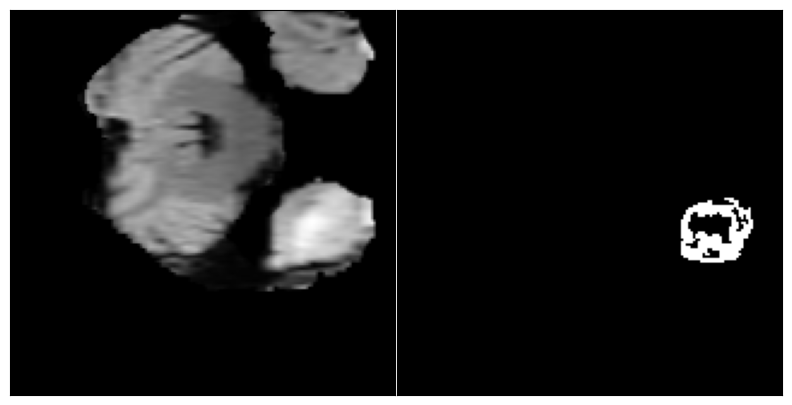

In [202]:
### Extracting out the patches from the figure
image, label = load_case(DATA_DIR + "imagesTr/BRATS_001.nii.gz", DATA_DIR + "labelsTr/BRATS_001.nii.gz")
X, y = get_sub_volume(image, label)
# enhancing tumor is channel 2 in the class label
# we can change indexer for y to look at different classes
util.visualize_patch(X[0, :, :, :], y[2])
print(X.shape, y.shape)

<a name="1-4-2"></a>
### 1.4.2 Standardization

Next, we will create a function that given a patch (sub-volume), standardizes the values across each channel and each Z plane to have a mean of zero and standard deviation of 1. 

In [386]:
def standardize(image):
    """
    Standardize mean and standard deviation 
        of each channel and z_dimension.

    Args:
        image (np.array): input image, 
            shape (num_channels, dim_x, dim_y, dim_z)

    Returns:
        standardized_image (np.array): standardized version of input image
    """
    
    # initialize to array of zeros, with same shape as the image
    standardized_image = np.zeros_like(image)

    # iterate over channels
    for c in range(image.shape[0]):
        # iterate over the `z` dimension
        for z in range(image.shape[3]):
            # get a slice of the image 
            # at channel c and z-th dimension `z`
            image_slice = image[c,:,:,z]
            print(image_slice)

            # subtract the mean from image_slice
            centered = image_slice - np.mean(image_slice)
            print(centered)
            
            # divide by the standard deviation (only if it is different from zero)
            centered_scaled = centered/(1 if np.std(centered) == 0 else np.std(centered))

            # update  the slice of standardized image
            # with the scaled centered and scaled image
            standardized_image[c, :, :, z] = centered_scaled

    return standardized_image

In [387]:
X_norm = standardize(X)
print("standard deviation for a slice should be 1.0")
print(f"stddv for X_norm[0, :, :, 0]: {X_norm[0,:,:,0].std():.2f}")

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[-248.96894531 -248.96894531 -248.96894531 ... -248.96894531
  -248.96894531 -248.96894531]
 [-248.96894531 -248.96894531 -248.96894531 ... -248.96894531
  -248.96894531 -248.96894531]
 [-248.96894531 -248.96894531 -248.96894531 ... -248.96894531
  -248.96894531 -248.96894531]
 ...
 [-248.96894531 -248.96894531 -248.96894531 ... -248.96894531
  -248.96894531 -248.96894531]
 [-248.96894531 -248.96894531 -248.96894531 ... -248.96894531
  -248.96894531 -248.96894531]
 [-248.96894531 -248.96894531 -248.96894531 ... -248.96894531
  -248.96894531 -248.96894531]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[-256.39230469 -256.39230469 -256.39230469 ... -256.39230469
  -256.39230469 -256.39230469]
 [-256.39230469 -256.39230469 -

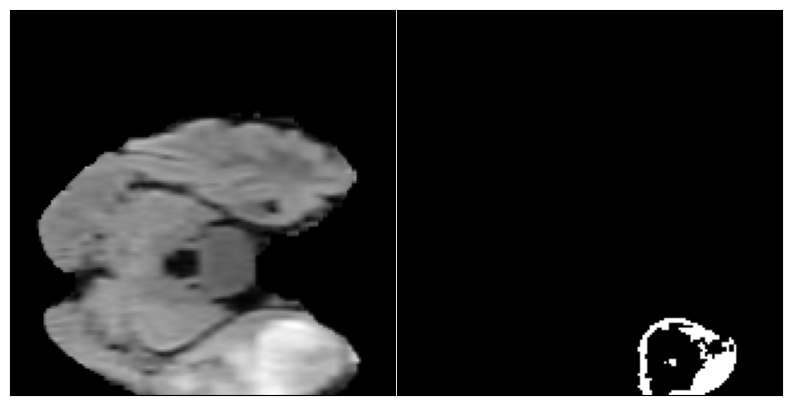

In [388]:
util.visualize_patch(X_norm[0, :, :, :], y[2])

<a name="2"></a>
# 2 Model: 3D U-Net
Now let's build our model. In this project we will be building a [3D U-net](https://arxiv.org/abs/1606.06650). 
- This architecture will take advantage of the volumetric shape of MR images and is one of the best performing models for this task. 
- [Reference paper](https://arxiv.org/abs/1606.06650).

<img src="https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png" width="50%">

<a name="3-1"></a>
## 3.1 Dice Similarity Coefficient

Aside from the architecture, one of the most important elements of any deep learning method is the choice of the loss function. 

A natural choice that we are familiar with is the cross-entropy loss function. 
- However, this loss function is not ideal for segmentation tasks due to **heavy class imbalance** (there are typically not many positive regions). 

A much more common loss function for segmentation tasks is the Dice similarity coefficient, which is a measure of how well two contours overlap. 
- The Dice index ranges from 0 (complete mismatch) to 1 (perfect match).

In general, for two sets $A$ and $B$, the Dice similarity coefficient is defined as: 
$$\text{DSC}(A, B) = \frac{2 \times |A \cap B|}{|A| + |B|}.$$

Here we can interpret $A$ and $B$ as sets of voxels, $A$ being the predicted tumor region and $B$ being the ground truth. 

Our model will map each voxel to 0 or 1
- 0 means it is a background voxel
- 1 means it is part of the segmented region.

In the dice coefficient, the variables in the formula are:
- $x$ : the input image
- $f(x)$ : the model output (prediction)
- $y$ : the label (actual ground truth)

The dice coefficient "DSC" is:

$$\text{DSC}(f, x, y) = \frac{2 \times \sum_{i, j} f(x)_{ij} \times y_{ij} + \epsilon}{\sum_{i,j} f(x)_{ij} + \sum_{i, j} y_{ij} + \epsilon}$$

- $\epsilon$ is a small number that is added to avoid division by zero

<img src="https://www.researchgate.net/publication/328671987/figure/fig4/AS:688210103529478@1541093483784/Calculation-of-the-Dice-similarity-coefficient-The-deformed-contour-of-the-liver-from.ppm" width="30%">

[Image Source](https://www.researchgate.net/figure/Calculation-of-the-Dice-similarity-coefficient-The-deformed-contour-of-the-liver-from_fig4_328671987)

Now let's implement the dice coefficient for a single output class:

- We can use the [Keras.sum(x,axis=)](https://www.tensorflow.org/api_docs/python/tf/keras/backend/sum) function to compute the numerator and denominator of the dice coefficient.

In [390]:
def single_class_dice_coefficient(y_true, y_pred, axis=(0, 1, 2), 
                                  epsilon=0.00001):
    """
    Compute dice coefficient for single class.

    Args:
        y_true (Tensorflow tensor): tensor of ground truth values for single class.
                                    shape: (x_dim, y_dim, z_dim)
        y_pred (Tensorflow tensor): tensor of predictions for single class.
                                    shape: (x_dim, y_dim, z_dim)
        axis (tuple): spatial axes to sum over when computing numerator and
                      denominator of dice coefficient.
                      Hint: pass this as the 'axis' argument to the K.sum function.
        epsilon (float): small constant added to numerator and denominator to
                        avoid divide by 0 errors.
    Returns:
        dice_coefficient (float): computed value of dice coefficient.     
    """
    
    dice_numerator = 2*K.sum(y_true*y_pred, axis = axis) + epsilon
    dice_denominator =  K.sum(y_true, axis = axis) + K.sum(y_pred, axis = axis) + epsilon
    dice_coefficient = dice_numerator/dice_denominator

    return dice_coefficient

### Dice Coefficient for Multiple classes
Now that we have the single class case, we can approach the multi class context. 
- For this task, we want segmentations for each of the 3 classes of abnormality (edema, enhancing tumor, non-enhancing tumor). 
- This will give us 3 different dice coefficients (one for each abnormality class). 
- To combine these, we can just take the average. We can write that the overall dice coefficient is: 

$$DC(f, x, y) = \frac{1}{3} \left ( DC_{1}(f, x, y) + DC_{2}(f, x, y) + DC_{3}(f, x, y) \right )$$

- $DC_{1}$, $DC_{2}$ and $DC_{3}$ are edema, enhancing tumor, and non-enhancing tumor dice coefficients.

For any number of classes, the equation becomes:  
$$DC(f, x, y) = \frac{1}{N} \sum_{c=1}^{C} \left ( DC_{c}(f, x, y) \right )$$

In this case, with three categories, $C = 3$

We implement the mean dice coefficient below:

- We can use the [K.mean](https://keras.io/backend/#mean) function to take the average of the three classes.  

In [392]:
def dice_coefficient(y_true, y_pred, axis=(1, 2, 3), 
                     epsilon=0.00001):
    """
    Compute mean dice coefficient over all abnormality classes.

    Args:
        y_true (Tensorflow tensor): tensor of ground truth values for all classes.
                                    shape: (num_classes, x_dim, y_dim, z_dim)
        y_pred (Tensorflow tensor): tensor of predictions for all classes.
                                    shape: (num_classes, x_dim, y_dim, z_dim)
        axis (tuple): spatial axes to sum over when computing numerator and
                      denominator of dice coefficient.
                      Hint: pass this as the 'axis' argument to the K.sum
                            and K.mean functions.
        epsilon (float): small constant add to numerator and denominator to
                        avoid divide by 0 errors.
    Returns:
        dice_coefficient (float): computed value of dice coefficient.     
    """
    
    dice_numerator = 2*K.sum(y_true*y_pred, axis = axis) + epsilon
    dice_denominator =  K.sum(y_true, axis = axis) + K.sum(y_pred, axis = axis) + epsilon
    dice_coefficient = K.mean(dice_numerator/dice_denominator)

    return dice_coefficient

<a name="3-2"></a>
## 3.2 Soft Dice Loss

While the Dice Coefficient makes intuitive sense, it is not the best for training. 
- This is because it takes in discrete values (zeros and ones). 
- The model outputs *probabilities* that each pixel is, say, a tumor or not, and we want to be able to backpropagate through those outputs. 

Therefore, we need an analogue of the Dice loss which takes real valued input. This is where the **Soft Dice loss** comes in. The formula is: 

$$\mathcal{L}_{Dice}(p, q) = 1 - \frac{2\times\sum_{i, j} p_{ij}q_{ij} + \epsilon}{\left(\sum_{i, j} p_{ij}^2 \right) + \left(\sum_{i, j} q_{ij}^2 \right) + \epsilon}$$

- $p$ is our predictions
- $q$ is the ground truth 
- In practice each $q_i$ will either be 0 or 1. 
- $\epsilon$ is a small number that is added to avoid division by zero

The soft Dice loss ranges between 
- 0: perfectly matching the ground truth distribution $q$
- 1: complete mismatch with the ground truth.

we can also check that if $p_i$ and $q_i$ are each 0 or 1, then the soft Dice loss is just one minus the dice coefficient.


### Multi-Class Soft Dice Loss

We've explained the single class case for simplicity, but the multi-class generalization is exactly the same as that of the dice coefficient. 
- Since we've already implemented the multi-class dice coefficient, we'll jump directly to the multi-class soft dice loss.

For any number of categories of diseases, the expression becomes:

$$\mathcal{L}_{Dice}(p, q) = 1 - \frac{1}{N} \sum_{c=1}^{C} \frac{2\times\sum_{i, j} p_{cij}q_{cij} + \epsilon}{\left(\sum_{i, j} p_{cij}^2 \right) + \left(\sum_{i, j} q_{cij}^2 \right) + \epsilon}$$

Let's implement the soft dice loss below:

In [393]:
def soft_dice_loss(y_true, y_pred, axis=(1, 2, 3), 
                   epsilon=0.00001):
    """
    Compute mean soft dice loss over all abnormality classes.

    Args:
        y_true (Tensorflow tensor): tensor of ground truth values for all classes.
                                    shape: (num_classes, x_dim, y_dim, z_dim)
        y_pred (Tensorflow tensor): tensor of soft predictions for all classes.
                                    shape: (num_classes, x_dim, y_dim, z_dim)
        axis (tuple): spatial axes to sum over when computing numerator and
                      denominator in formula for dice loss.
                      Hint: pass this as the 'axis' argument to the K.sum
                            and K.mean functions.
        epsilon (float): small constant added to numerator and denominator to
                        avoid divide by 0 errors.
    Returns:
        dice_loss (float): computed value of dice loss.     
    """

    dice_numerator = 2*K.sum(y_true*y_pred, axis = axis) + epsilon
    dice_denominator = K.sum(y_true**2, axis = axis) + K.sum(y_pred**2, axis = axis) + epsilon
    dice_loss = 1 - K.mean(dice_numerator/dice_denominator)

    return dice_loss

<a name="4"></a>
# 4 Create and Train the model

Now that we've finished implementing the soft dice loss, we can create the model! 

We'll use the `unet_model_3d` function in `utils` to creates the model architecture and compile the model with the specified loss functions and metrics. 